![Python Logo](./img/python-logo-master-v3-TM-flattened_small.png)

# Financial Programming - IÉSEG, Lille - MBD 2019-2020
## Group Project - Financial Data

In [1]:
first_name = ''
last_name = ''

### Data Exploration

In [659]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import math
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals()) 
import warnings
warnings.filterwarnings("ignore")

**Input data**

In [3]:
# Each record describes static characteristics of an account
account = pd.read_csv('./data_berka/account.asc', sep=';')
account.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


In [4]:
# Each record describes a credit card issued to an account
card = pd.read_csv('./data_berka/card.asc', sep=';')
card.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [5]:
# Each record describes characteristics of a client
client = pd.read_csv('./data_berka/client.asc', sep=';')
client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [6]:
# Each record relates together a client with an account i.e. this relation describes the rights
# of clients to operate accounts
disp = pd.read_csv('./data_berka/disp.asc', sep=';')
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [7]:
# Each record describes characteristics of a payment order
order = pd.read_csv('./data_berka/order.asc', sep=';')
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [8]:
# Each record describes one transaction on an account
trans = pd.read_csv('./data_berka/trans.asc', sep=';', low_memory=False)
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [9]:
# Each record describes a loan granted for a given account
loan = pd.read_csv('./data_berka/loan.asc', sep=';')
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [10]:
# Each record describes demographic characteristics of a district.
district = pd.read_csv('./data_berka/district.asc', sep=';')
district.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


# Task description
The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client
(whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses).
Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already
granted, the credit cards issued. The bank managers hope to improve their understanding of customers and seek specific
actions to improve services. A mere application of a discovery tool will not be convincing for them.

To fulfill this task, we have split the project into the following steps:
1. Data preparation: cleaning, formatting and aggregating data
2. Merging dataframes: to achieve a final datamart to analyze data
3. Profiles: looking at variables to understand customers and their behavior
4. Plots: to look at general bank data to put profiles into context
5. Conclusions

# 1. Data Preparation
Creating additional variables and cleaning tables, the final goal of this step is to aggregate tables by account and client id to later merge them easily and without duplicate information.

In [11]:
#Adding more demographic variables for segmentation: birth information and gender
client["birth_year"] = ('19'+client["birth_number"].astype(str).str[0:2]).astype(int)
client["birth_day"] = (client["birth_number"].astype(str).str[-2:]).astype(int)
client["birth_month"] = (client["birth_number"].astype(str).str[2:4]).astype(int)
client["g"] = 'M'
client.loc[client["birth_month"]>12,'g'] = 'F'
client.loc[client["birth_month"]>12,'birth_month'] = client['birth_month']-50

In [12]:
cutoff = datetime.datetime(1999, 12, 31, 0, 0).date() #cutoff date for age calculation
client["age"] = 0

for i in range(0,len(client)):
    birth = datetime.date(client.loc[i,"birth_year"],client.loc[i,"birth_month"],client.loc[i,"birth_day"])
    client.loc[i,"age"] = math.floor((cutoff - birth).days/365)
    
client["age_group"] = client["age"]//10*10
client.describe()

,client_id,birth_number,district_id,birth_year,birth_day,birth_month,age,age_group
count,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000
mean,3359.011920,535114.970013,37.310114,1953.198361,15.957161,6.521885,45.831812,41.363382
std,2832.911984,172895.618429,25.043690,17.282283,8.796721,3.432381,17.294283,17.412866
min,1.000000,110820.000000,1.000000,1911.000000,1.000000,1.000000,12.000000,10.000000
25%,1418.000000,406009.000000,14.000000,1940.000000,8.000000,4.000000,31.000000,30.000000
50%,2839.000000,540829.000000,38.000000,1954.000000,16.000000,7.000000,45.000000,40.000000
75%,4257.000000,681013.000000,60.000000,1968.000000,24.000000,9.000000,59.000000,50.000000
max,13998.000000,875927.000000,77.000000,1987.000000,31.000000,12.000000,88.000000,80.000000


In [13]:
client.drop(columns=["birth_number","birth_year","birth_day","birth_month"], inplace=True)

In [14]:
#translating frequency for readability
account["frequency"]=account["frequency"].replace("POPLATEK MESICNE", "Monthly Issuance")
account["frequency"]=account["frequency"].replace("POPLATEK PO OBRATU", "Issue after transaction")
account["frequency"]=account["frequency"].replace("POPLATEK TYDNE", "Weekly Issuance")

In [15]:
#Cleaning account date
account["date"] = ('19'+account["date"].astype(str).str[:2])+'/' \
                        +(account["date"].astype(str).str[2:4])+'/' \
                        +(account['date'].astype(str).str[4:6])
account["date"] = pd.to_datetime(account["date"], format='%Y/%m/%d')

account.head()

,account_id,district_id,frequency,date
0,576,55,Monthly Issuance,1993-01-01
1,3818,74,Monthly Issuance,1993-01-01
2,704,55,Monthly Issuance,1993-01-01
3,2378,16,Monthly Issuance,1993-01-01
4,2632,24,Monthly Issuance,1993-01-02


In [16]:
#encoding disp table type
disp.loc[disp["type"]=="OWNER","type"]=1
disp.loc[disp["type"]=="DISPONENT","type"]=0
disp = disp.rename(columns={'type': 'owner'})
disp.head()

,disp_id,client_id,account_id,owner
0,1,1,1,1
1,2,2,2,1
2,3,3,2,0
3,4,4,3,1
4,5,5,3,0


In [17]:
#Cleaning card table
card["date"] = ('19'+card["issued"].astype(str).str[:2])+'/' \
                        +(card["issued"].astype(str).str[2:4])+'/' \
                        +(card['issued'].astype(str).str[4:6])
card["date"] = pd.to_datetime(card["date"], format='%Y/%m/%d')

card=card.drop("issued", axis=1)

#creating dummy variable, later missing values are filled with 0
card["owner"] = 1

card.head()

,card_id,disp_id,type,date,owner
0,1005,9285,classic,1993-11-07,1
1,104,588,classic,1994-01-19,1
2,747,4915,classic,1994-02-05,1
3,70,439,classic,1994-02-08,1
4,577,3687,classic,1994-02-15,1


In [18]:
#translating values for readability
order["k_symbol"]=order["k_symbol"].replace("SIPO", "hh_payment")
order["k_symbol"]=order["k_symbol"].replace("UVER", "loan_payment")
order["k_symbol"]=order["k_symbol"].replace("LEASING", "leasing")
order["k_symbol"]=order["k_symbol"].replace("POJISTNE", "insr_payment")
order["k_symbol"]=order["k_symbol"].replace(" ", "Unknown")

In [19]:
#group order by account_id to later merge it
order["leasing"]=0
order["hh_payment"]=0
order["loan_payment"]=0
order["insr_payment"]=0
order.loc[order['k_symbol'] == 'leasing', 'leasing']= order.loc[order['k_symbol'] == 'leasing','amount']
order.loc[order['k_symbol'] == 'hh_payment', 'hh_payment']= order.loc[order['k_symbol'] == 'hh_payment','amount']
order.loc[order['k_symbol'] == 'loan_payment', 'loan_payment']= order.loc[order['k_symbol'] == 'loan_payment','amount']
order.loc[order['k_symbol'] == 'insr_payment', 'insr_payment']= order.loc[order['k_symbol'] == 'insr_payment','amount']

order.drop(columns=["order_id","account_to","k_symbol"], inplace=True)

order=order.groupby(['account_id']).sum().reset_index()
order.head()

,account_id,amount,leasing,hh_payment,loan_payment,insr_payment
0,1,2452.0,0.0,2452.0,0.0,0.0
1,2,10638.7,0.0,7266.0,3372.7,0.0
2,3,5001.0,0.0,1135.0,0.0,3539.0
3,4,3363.0,0.0,3363.0,0.0,0.0
4,5,2668.0,0.0,2668.0,0.0,0.0


In [20]:
district = district.rename(columns={'A1': 'district_id', 'A2': 'dist_name','A3': 'dist_region', 'A4': 'nb_habitants',
                                    'A9': 'nb_cities', 'A10': 'ratio_urban',
                                   'A11': 'avg_salary', 'A12': 'unemp_95','A13': 'unemp_96', 'A14': 'nb_entrepreneurs',
                                   'A15': 'crimes_95', 'A16': 'crimes_96'})
#district=district.drop(["A5","A6","A7","A8","nb_cities","unemp_95","crimes_95"], axis=1)
district=district.drop(["A5","A6","A7","A8","nb_cities"], axis=1)
district.head()

,district_id,dist_name,dist_region,nb_habitants,ratio_urban,avg_salary,unemp_95,unemp_96,nb_entrepreneurs,crimes_95,crimes_96
0,1,Hl.m. Praha,Prague,1204953,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,51.4,9307,3.85,4.43,118,2616,3040


In [21]:
#Turn transaction type into a dummy
trans["credit"] = (trans["type"]=="PRIJEM").astype(int)
trans["withdrawal"] = 0
trans.loc[(trans["type"] == "VYDAJ") | (trans["type"] == "VYBER"),"withdrawal"] = 1

In [22]:
#Turn k symbol into a dummy
trans["k_symbol"].replace({"DUCHOD": "oldage_pension", "POJISTNE": "insurance", "SANKC. UROK":"sanction","SIPO":"household",
                          "SLUZBY":"statement","UROK":"interest","UVER":"loan"},inplace=True)
trans["k_symbol"]=trans["k_symbol"].fillna('UNKNOWN')
trans.loc[trans["k_symbol"]==' ','k_symbol'] = 'UNKNOWN'
trans_dummies = pd.get_dummies(trans[["k_symbol"]])
trans = pd.concat([trans,trans_dummies],axis=1)

In [23]:
#cleaning transaction dates
trans["date_clean"] = ('19'+trans["date"].astype(str).str[0:2])+'/' \
                        +(trans["date"].astype(str).str[2:4])+'/' \
                        +(trans["date"].astype(str).str[-2:])
trans["date_clean"] = pd.to_datetime(trans["date_clean"], format='%Y/%m/%d')
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,...,withdrawal,k_symbol_UNKNOWN,k_symbol_household,k_symbol_insurance,k_symbol_interest,k_symbol_loan,k_symbol_oldage_pension,k_symbol_sanction,k_symbol_statement,date_clean
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-02


In [24]:
#cleaning loan dates
loan["date"] = ('19'+loan["date"].astype(str).str[0:2])+'/' \
                        +(loan["date"].astype(str).str[2:4])+'/' \
                        +(loan["date"].astype(str).str[-2:])
loan["date"] = pd.to_datetime(loan["date"], format='%Y/%m/%d')
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [25]:
#adding amount to each transaction type and operation
trans["withdrawal"]=(trans["amount"])*trans["withdrawal"]
trans["credit"]=(trans["amount"])*trans["credit"]

trans["k_symbol_household"]=(trans["amount"])*trans["k_symbol_household"]
trans["k_symbol_insurance"]=(trans["amount"])*trans["k_symbol_insurance"]
trans["k_symbol_interest"]=(trans["amount"])*trans["k_symbol_interest"]
trans["k_symbol_loan"]=(trans["amount"])*trans["k_symbol_loan"]
trans["k_symbol_oldage_pension"]=(trans["amount"])*trans["k_symbol_oldage_pension"]
trans["k_symbol_sanction"]=(trans["amount"])*trans["k_symbol_sanction"]
trans["k_symbol_statement"]=(trans["amount"])*trans["k_symbol_statement"]

trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,...,withdrawal,k_symbol_UNKNOWN,k_symbol_household,k_symbol_insurance,k_symbol_interest,k_symbol_loan,k_symbol_oldage_pension,k_symbol_sanction,k_symbol_statement,date_clean
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-02


In [26]:
#average transaction frequency per account
n = 0
acc_datediff = pd.DataFrame(columns=["account_id","datediff"])

for i in pd.unique(trans["account_id"]):
    date_df = trans[trans["account_id"]==i][["date_clean"]]
    date_df.reset_index(drop=True,inplace=True)
    date_df["shift"] = date_df["date_clean"].shift(1)
    date_df["diff"] = (date_df["date_clean"] - date_df["shift"]).astype('timedelta64[D]')
    acc_datediff.loc[n,"account_id"] = i
    acc_datediff.loc[n,"datediff"] = date_df["diff"].mean()
    n += 1

acc_datediff["account_id"] = acc_datediff["account_id"].astype(int)
acc_datediff.head()

,account_id,datediff
0,2378,5.04608
1,576,6.13445
2,704,4.58159
3,3818,3.91771
4,1972,5.94837


In [27]:
#grouping by account id and dropping redundant columns
trans_agg = pysqldf("""Select t.account_id,ad.datediff,min(t.date_clean) as first_trans,max(t.date_clean) as last_trans
                            ,count(t.trans_id) as n_trans,sum(t.amount) as sum_amount,avg(t.amount) as avg_amount
                            ,sum(t.credit) as credit,sum(t.withdrawal) as withdrawal
                            ,sum(t.k_symbol_household) as household_amount,sum(t.k_symbol_insurance) as insurance_amount
                            ,sum(t.k_symbol_interest) as interest_amount,sum(t.k_symbol_loan) as loan_amount
                            ,sum(t.k_symbol_oldage_pension) as pension_amount,sum(t.k_symbol_sanction) as sanction_amount
                            ,sum(t.k_symbol_statement) as statement_amount
                                     from trans t
                                     left join acc_datediff ad on ad.account_id=t.account_id
                                     group by 1,2
                         """)

In [28]:
#adding interest rate per account column
trans_agg["int_rate"]=trans_agg["interest_amount"]/trans_agg["sum_amount"]

In [29]:
trans_agg.head()

,account_id,datediff,first_trans,last_trans,n_trans,sum_amount,avg_amount,credit,withdrawal,household_amount,insurance_amount,interest_amount,loan_amount,pension_amount,sanction_amount,statement_amount,int_rate
0,1,5.789916,1995-03-24 00:00:00.000000,1998-12-31 00:00:00.000000,239,375174.5,1569.767782,194320.5,180854.0,98080.0,0.0,3065.5,0.0,0.0,0.0,584.0,0.008171
1,2,4.473795,1993-02-26 00:00:00.000000,1998-12-31 00:00:00.000000,478,3151479.3,6593.052929,1597053.5,1554425.8,472290.0,0.0,10717.5,80944.8,0.0,0.0,949.0,0.003401
2,3,4.672414,1997-07-07 00:00:00.000000,1998-12-31 00:00:00.000000,117,295021.8,2521.553846,173059.0,121962.8,14755.0,46007.0,2070.0,0.0,0.0,0.0,189.8,0.007016
3,4,5.643243,1996-02-21 00:00:00.000000,1998-12-31 00:00:00.000000,186,350971.4,1886.943011,192346.0,158625.4,60262.0,0.0,2744.0,0.0,188802.0,0.0,423.4,0.007818
4,5,6.987952,1997-05-30 00:00:00.000000,1998-12-31 00:00:00.000000,84,166881.4,1986.683333,97485.0,69396.4,37352.0,0.0,1562.0,0.0,95323.0,0.0,204.4,0.009360


# 2. Merging Dataframes
Tables were aggregated on a customer/account level to be able to look at different variables more in depth

In [30]:
#Adding prefix to all tables before merging
account = account.add_prefix('acc_')
card = card.add_prefix('cc_')
client = client.add_prefix('cust_')
disp = disp.add_prefix('disp_')
district = district.add_prefix('dist_')
order = order.add_prefix('ord_')
loan = loan.add_prefix('loan_')
trans_agg = trans_agg.add_prefix('trans_')

In [31]:
account_loans = pd.merge(account, loan, how="left",  left_on="acc_account_id",right_on='loan_account_id')
al_trans = pd.merge(account_loans, trans_agg, how="left",  left_on="acc_account_id",right_on='trans_account_id')
alt_disp = pd.merge(al_trans, disp, how="left",  left_on="acc_account_id",right_on='disp_account_id')
altd_card = pd.merge(alt_disp, card, how="left",  left_on="disp_disp_id",right_on='cc_disp_id')
altdc_district = pd.merge(altd_card, district, how="left",  left_on="acc_district_id",right_on='dist_district_id')
altdcd_client = pd.merge(altdc_district, client, how="left",  left_on="disp_client_id",right_on='cust_client_id')
final_merge = pd.merge(altdcd_client, order, how="left",  left_on="acc_account_id",right_on='ord_account_id')

In [32]:
#dropping redundant ID columns
keep = ["acc_account_id","loan_loan_id","trans_trans_id","disp_disp_id","cc_card_id","cust_client_id","ord_order_id"]
acc_id = [s for s in final_merge.columns if "_id" in s]
acc_id = [s for s in acc_id if s not in keep]
print(acc_id)

final_merge.drop(columns=acc_id, axis=1, inplace=True)
final_merge.head()

['acc_district_id', 'loan_account_id', 'trans_account_id', 'disp_client_id', 'disp_account_id', 'cc_disp_id', 'dist_district_id', 'cust_district_id', 'ord_account_id']


,acc_account_id,acc_frequency,acc_date,loan_loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,trans_datediff,...,dist_crimes_96,cust_client_id,cust_g,cust_age,cust_age_group,ord_amount,ord_leasing,ord_hh_payment,ord_loan_payment,ord_insr_payment
0,576,Monthly Issuance,1993-01-01,NaN,NaT,NaN,NaN,NaN,NaN,6.134454,...,3894,692,F,64,60,3662.0,0.0,3662.0,0.0,0.0
1,576,Monthly Issuance,1993-01-01,NaN,NaT,NaN,NaN,NaN,NaN,6.134454,...,3894,693,M,64,60,3662.0,0.0,3662.0,0.0,0.0
2,3818,Monthly Issuance,1993-01-01,NaN,NaT,NaN,NaN,NaN,NaN,3.917710,...,18347,4601,M,64,60,9135.0,0.0,3596.0,0.0,4065.0
3,3818,Monthly Issuance,1993-01-01,NaN,NaT,NaN,NaN,NaN,NaN,3.917710,...,18347,4602,F,65,60,9135.0,0.0,3596.0,0.0,4065.0
4,704,Monthly Issuance,1993-01-01,NaN,NaT,NaN,NaN,NaN,NaN,4.581590,...,3894,844,M,54,50,3338.0,0.0,2141.0,0.0,0.0


In [33]:
#checking date columns
date_cols = [s for s in final_merge.columns if "date" in s]
date_cols.insert(0,"acc_account_id")
date_cols.insert(2,"trans_first_trans")
date_df = final_merge[date_cols]
date_df[pd.to_datetime(date_df["trans_first_trans"])!=pd.to_datetime(date_df["acc_date"])]

#first transaction date is the same as account opening date, so column is dropped because of redundant information
final_merge.drop(columns="trans_first_trans",inplace=True)

In [34]:
#creating difference in days for credit card creation
final_merge["cc_create_time"] = (final_merge["cc_date"]-final_merge["acc_date"]).dt.days
final_merge["loan_create_time"] = (final_merge["loan_date"]-final_merge["acc_date"]).dt.days

In [35]:
final_merge.describe()

,acc_account_id,loan_loan_id,loan_amount,loan_duration,loan_payments,trans_datediff,trans_n_trans,trans_sum_amount,trans_avg_amount,trans_credit,...,cust_client_id,cust_age,cust_age_group,ord_amount,ord_leasing,ord_hh_payment,ord_loan_payment,ord_insr_payment,cc_create_time,loan_create_time
count,5369.000000,827.000000,827.000000,827.000000,827.000000,5369.000000,5369.000000,5.369000e+03,5369.000000,5.369000e+03,...,5369.000000,5369.000000,5369.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,892.000000,827.000000
mean,2767.496927,6180.746070,151801.538089,36.261185,4231.251511,6.040723,235.169492,1.381196e+06,5690.169751,7.123908e+05,...,3359.011920,45.831812,41.363382,5656.990526,192.451360,3735.299123,818.045307,183.073026,777.374439,400.457074
std,2307.843630,681.292733,114577.041848,17.172800,2238.757849,3.545952,127.676758,1.335580e+06,4018.079842,6.738228e+05,...,2832.911984,17.294283,17.412866,3820.924782,715.722002,2948.830228,1949.628119,800.899307,464.567606,164.900811
min,1.000000,4959.000000,4980.000000,12.000000,304.000000,2.600583,9.000000,2.940000e+04,843.435519,1.970000e+04,...,1.000000,12.000000,10.000000,312.000000,0.000000,0.000000,0.000000,0.000000,203.000000,102.000000
25%,1178.000000,5585.000000,67536.000000,24.000000,2495.500000,4.787440,133.000000,4.200838e+05,2271.898765,2.248333e+05,...,1418.000000,31.000000,30.000000,2703.750000,0.000000,1852.000000,0.000000,0.000000,394.500000,267.000000
50%,2349.000000,6190.000000,115992.000000,36.000000,3937.000000,5.564356,209.000000,8.756193e+05,4595.870357,4.595772e+05,...,2839.000000,45.000000,40.000000,4456.000000,0.000000,3053.500000,0.000000,0.000000,658.500000,398.000000
75%,3526.000000,6760.500000,210564.000000,48.000000,5916.000000,6.335463,330.000000,1.938205e+06,8272.470370,9.973781e+05,...,4257.000000,59.000000,50.000000,7610.250000,0.000000,5288.750000,0.000000,0.000000,1040.000000,533.000000
max,11382.000000,7308.000000,590820.000000,60.000000,9910.000000,63.750000,675.000000,7.619102e+06,21062.613287,3.857257e+06,...,13998.000000,88.000000,80.000000,22704.300000,4975.200000,14882.000000,9910.000000,12504.000000,2147.000000,697.000000


In [41]:
#replacing missing values from final merged dataframe
final_merge["loan_loan_id"]=final_merge["loan_loan_id"].fillna(0).astype(int)          
final_merge["loan_amount"]=final_merge["loan_amount"].fillna(0).astype(int)        
final_merge["loan_duration"]=final_merge["loan_duration"].fillna(0).astype(int)        
final_merge["loan_payments"]=final_merge["loan_payments"].fillna(0).astype(int)        
final_merge["loan_status"]=final_merge["loan_status"].fillna('NA')
final_merge["loan_date"]=final_merge["loan_date"].fillna('9999-01-01')
final_merge["loan_create_time"]=final_merge["loan_create_time"].fillna(0).astype(int)
final_merge["cc_card_id"]=final_merge["cc_card_id"].fillna(0).astype(int)
final_merge["cc_type"]=final_merge["cc_type"].fillna('NA')
final_merge["cc_owner"]=final_merge["cc_owner"].fillna(0).astype(int)
final_merge["cc_date"]=final_merge["cc_date"].fillna('9999-01-01')
final_merge["cc_date"]=final_merge["cc_date"].fillna('9999-01-01')
final_merge["cc_create_time"]=final_merge["cc_create_time"].fillna(0).astype(int)
final_merge["ord_leasing"]=final_merge["ord_leasing"].fillna(0).astype(int)
final_merge["ord_hh_payment"]=final_merge["ord_hh_payment"].fillna(0).astype(int)
final_merge["ord_loan_payment"]=final_merge["ord_loan_payment"].fillna(0).astype(int)
final_merge["ord_insr_payment"]=final_merge["ord_insr_payment"].fillna(0).astype(int)

In [494]:
#final variables
final_merge.columns

Index(['acc_account_id', 'acc_frequency', 'acc_date', 'loan_loan_id',
       'loan_date', 'loan_amount', 'loan_duration', 'loan_payments',
       'loan_status', 'trans_datediff', 'trans_last_trans', 'trans_n_trans',
       'trans_sum_amount', 'trans_avg_amount', 'trans_credit',
       'trans_withdrawal', 'trans_household_amount', 'trans_insurance_amount',
       'trans_interest_amount', 'trans_loan_amount', 'trans_pension_amount',
       'trans_sanction_amount', 'trans_statement_amount', 'trans_int_rate',
       'disp_disp_id', 'disp_owner', 'cc_card_id', 'cc_type', 'cc_date',
       'cc_owner', 'dist_dist_name', 'dist_dist_region', 'dist_nb_habitants',
       'dist_ratio_urban', 'dist_avg_salary', 'dist_unemp_95', 'dist_unemp_96',
       'dist_nb_entrepreneurs', 'dist_crimes_95', 'dist_crimes_96',
       'cust_client_id', 'cust_g', 'cust_age', 'cust_age_group', 'ord_amount',
       'ord_leasing', 'ord_hh_payment', 'ord_loan_payment', 'ord_insr_payment',
       'cc_create_time', 'loan_

# 3. Profiles
Different variables were looked at to explore two initial client segments: those sharing an account and those not sharing an account

In [43]:
#Creating dataframes to compare data for shared versus single owner (exclusive) accounts
clients_accs = final_merge[['cust_client_id','acc_account_id']].groupby('acc_account_id').count()

shared_accs = final_merge[final_merge["acc_account_id"].isin(list(clients_accs[clients_accs['cust_client_id']==2].index))]
exclusive_accs = final_merge[final_merge["acc_account_id"].isin(list(clients_accs[clients_accs['cust_client_id']==1].index))]

In [83]:
#Gender distribution dataframe for clients who don't share accounts
exc_count=exclusive_accs.groupby("cust_g")["cust_client_id"].count().reset_index()
exc_count=pd.DataFrame(exc_count)
exc_count.columns = ['gender', 'clients']

#Gender distribution dataframe for clients who share accounts, one dataframe for account owners, one for non-owners
shrd_own_count=shared_accs[shared_accs["disp_owner"]==1].groupby("cust_g")["cust_client_id"].count().reset_index()
shrd_own_count=pd.DataFrame(shrd_own_count)
shrd_own_count.columns = ['gender', 'clients']

shrd_disp_count=shared_accs[shared_accs["disp_owner"]==0].groupby("cust_g")["cust_client_id"].count().reset_index()
shrd_disp_count=pd.DataFrame(shrd_disp_count)
shrd_disp_count.columns = ['gender', 'clients']

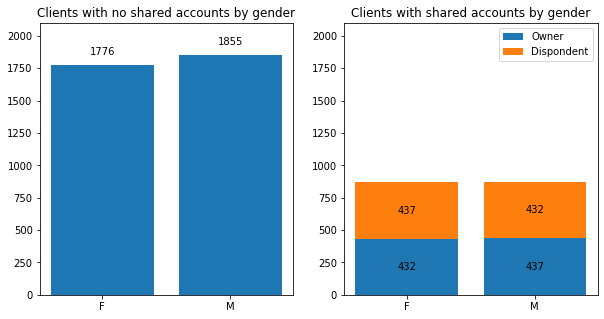

In [132]:
#Plotting Gender for all groups
f = plt.figure(figsize=(10, 5))
f.add_subplot(1,2,1)
plt.ylim(0, 2100)
plt.bar(exc_count["gender"],exc_count['clients'])
plt.title('Clients with no shared accounts by gender')

for x,y in exc_count.values:
    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

f.add_subplot(1,2,2)
p1 = plt.bar(shrd_own_count["gender"],shrd_own_count['clients'])
p2 = plt.bar(shrd_disp_count["gender"],shrd_disp_count['clients'],
             bottom=shrd_own_count['clients'])
for r1,r2 in zip(p1,p2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center")

plt.ylim(0, 2100)
plt.title('Clients with shared accounts by gender')
plt.legend((p1[0], p2[0]), ('Owner', 'Dispondent'))
plt.show()

In [164]:
#Looking at average age differences for shared accounts
shared_accs["owner_age"]=shared_accs.loc[shared_accs["disp_owner"]==1,"cust_age"]
shared_accs["disp_age"]=shared_accs.loc[shared_accs["disp_owner"]==0,"cust_age"]
shared_accs["disp_age"] = shared_accs["disp_age"].shift(-1)

age_diff = shared_accs[shared_accs["disp_owner"]==1][["acc_account_id","owner_age","disp_age"]]
age_diff = age_diff[age_diff["owner_age"]!=age_diff["disp_age"]]
age_diff["diff"] = abs(age_diff["owner_age"] - age_diff["disp_age"])
age_diff["diff"].mean()

#Low age difference and gender distribution suggests possibility of shared accounts mostly belonging to couples

4.301818181818182

Text(0.5, 1.0, 'Age Distribution')

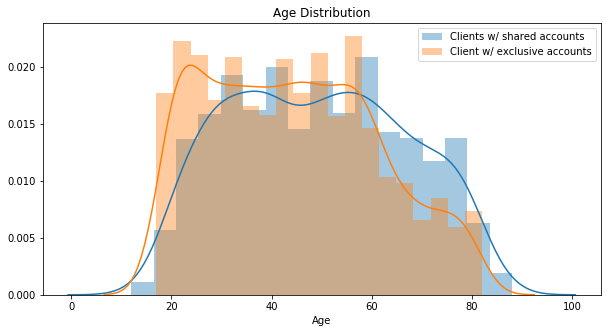

In [220]:
f = plt.figure(figsize=(10, 5))
sns.distplot(shared_accs['cust_age'])
sns.distplot(exclusive_accs['cust_age'])
plt.xlabel('Age', color = 'black', fontsize='10', horizontalalignment='center')
plt.legend(labels=['Clients w/ shared accounts', 'Client w/ exclusive accounts'])
plt.title('Age Distribution')

In [178]:
#Looking at age distribution for exclusive and shared accounts
print(exclusive_accs["cust_age"].describe()) #std dev: 16.87, 50%: 43, mean: 44, max: 82, min: 17
print(shared_accs["cust_age"].describe()) #std dev: 17.64, 50%: 49, mean: 49, max: 88, min: 12

#Exclusive accounts belong to younger people on average

count    3631.000000
mean       44.158083
std        16.870265
min        17.000000
25%        30.000000
50%        43.000000
75%        57.000000
max        82.000000
Name: cust_age, dtype: float64
count    1738.000000
mean       49.328539
std        17.647893
min        12.000000
25%        35.000000
50%        49.000000
75%        63.000000
max        88.000000
Name: cust_age, dtype: float64


In [349]:
#Looking at regional distribution in %
reg_shared = shared_accs.groupby("dist_dist_region")["cust_client_id"].count()/shared_accs["cust_client_id"].count()*100
reg_shared = reg_shared.reset_index()
reg_shared["Group"] = "Shared Accounts"

reg_exclusive = exclusive_accs.groupby("dist_dist_region")["cust_client_id"].count()/ \
                        exclusive_accs["cust_client_id"].count()*100
reg_exclusive = reg_exclusive.reset_index()
reg_exclusive["Group"] = "Exclusive Accounts"

reg_total = pd.concat([reg_shared,reg_exclusive])

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

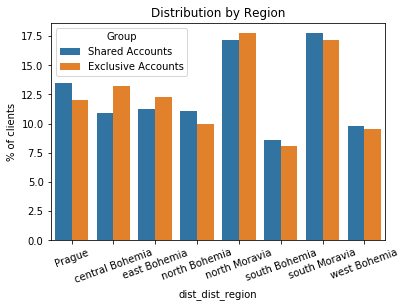

In [350]:
ax = sns.barplot(x="dist_dist_region", y="cust_client_id", hue="Group", data=reg_total)
ax.set_ylabel("% of clients")
plt.title('Distribution by Region')
plt.xticks(rotation=20)

Exclusive accounts with cards:20.0%
Exclusive accounts average time to get a card:772

Shared accounts with cards:17.0%
Shared accounts average time to get a card:804


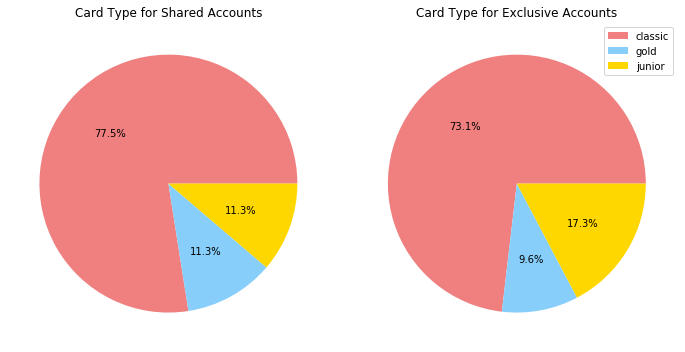

In [343]:
#Looking at Credit Card data
#For shared accounts, we will only be looking at owners to avoid duplicate information
exc_card = exclusive_accs[exclusive_accs['cc_owner']==1]
print("Exclusive accounts with cards:"+
      str(round(exc_card["cust_client_id"].count()/
                exclusive_accs["cust_client_id"].count()*100))+'%')
print("Exclusive accounts average time to get a card:"+
      str(round(exc_card["cc_create_time"].mean())))
print('')
shard_card = shared_accs[(shared_accs['cc_owner']==1)&(shared_accs["disp_owner"]==1)]
print("Shared accounts with cards:"+
      str(round(shard_card["cust_client_id"].count()/
                shared_accs[shared_accs["disp_owner"]==1]["cust_client_id"].count()*100))+'%')
print("Shared accounts average time to get a card:"+
      str(round(shard_card["cc_create_time"].mean())))

#Plotting card type distribution
f = plt.figure(figsize=(10, 5))
f.add_subplot(1,2,1)
labels = list(shard_card.groupby("cc_type")["acc_account_id"].count().index)
sizes = list(shard_card.groupby("cc_type")["acc_account_id"].count())
colors = ['lightcoral','lightskyblue', 'gold']
plt.pie(sizes, colors=colors,autopct='%1.1f%%')
plt.title("Card Type for Shared Accounts")
plt.tight_layout()

f.add_subplot(1,2,2)
labels = list(exc_card.groupby("cc_type")["acc_account_id"].count().index)
sizes = list(exc_card.groupby("cc_type")["acc_account_id"].count())
colors = ['lightcoral','lightskyblue', 'gold']
plt.pie(sizes, colors=colors,autopct='%1.1f%%')
plt.legend(patches, labels, loc="best")
plt.title("Card Type for Exclusive Accounts")
plt.tight_layout()

Exclusive accounts with loans:15.0%
Exclusive accounts average time to get a loan:395
Exclusive accounts average loan amount:150807
Exclusive accounts average loan duration:37

Shared accounts with loans:17.0%
Shared accounts average time to get a loan:411
Shared accounts average loan amount:153642
Shared accounts average loan duration:35


Text(0.5, 1.0, 'Distribution by Loan Status')

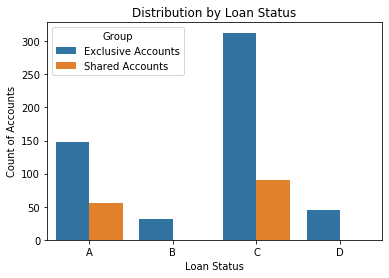

In [345]:
#Looking at Loan data
#For shared accounts, we will only be looking at owners to avoid duplicate information
exc_loan = exclusive_accs[exclusive_accs['loan_create_time']!=0]
print("Exclusive accounts with loans:"+
      str(round(exc_loan["cust_client_id"].count()/
                exclusive_accs["cust_client_id"].count()*100))+'%')
print("Exclusive accounts average time to get a loan:"+
      str(round(exc_loan["loan_create_time"].mean())))
print("Exclusive accounts average loan amount:"+
      str(round(exc_loan["loan_amount"].mean())))
print("Exclusive accounts average loan duration:"+
      str(round(exc_loan["loan_duration"].mean())))
print("")
shared_loan = shared_accs[(shared_accs['loan_create_time']!=0)&(shared_accs["disp_owner"]==1)]
print("Shared accounts with loans:"+
      str(round(shared_loan["cust_client_id"].count()/
                shared_accs[shared_accs["disp_owner"]==1]["cust_client_id"].count()*100))+'%')
print("Shared accounts average time to get a loan:"+
      str(round(shared_loan["loan_create_time"].mean())))
print("Shared accounts average loan amount:"+
      str(round(shared_loan["loan_amount"].mean())))
print("Shared accounts average loan duration:"+
      str(round(shared_loan["loan_duration"].mean())))

#Looking at loan type by group
# - 'A': contract finished, no problems,
# - 'B': contract finished, loan not payed,
# - 'C': running contract, OK so far,
# - 'D': running contract, client in debt
shared_loan['Group']="Shared Accounts"
exc_loan['Group']="Exclusive Accounts"

loan_total = pd.concat([shared_loan[['acc_account_id','loan_status','Group']],
                        exc_loan[['acc_account_id','loan_status','Group']]])
loan_total = loan_total.groupby(["Group","loan_status"])["acc_account_id"].count().reset_index()
ax = sns.barplot(x="loan_status", y="acc_account_id", hue="Group", data=loan_total, ci=None)
ax.set_ylabel("Count of Accounts")
ax.set_xlabel("Loan Status")
plt.title('Distribution by Loan Status')

In [425]:
#cross-sell: we will consider household, insurance & loan as banking products, other flags are to look at average amounts
cross_sell = pysqldf("""select account_id,max(case when k_symbol_household>0 then 1 else 0 end) as hh,
                            max(case when k_symbol_insurance>0 then 1 else 0 end) as ins,
                            max(case when k_symbol_interest>0 then 1 else 0 end) as int,
                            max(case when k_symbol_loan>0 then 1 else 0 end) as loan,
                            max(case when k_symbol_oldage_pension>0 then 1 else 0 end) as oap,
                            max(case when k_symbol_sanction>0 then 1 else 0 end) as sanc,
                            max(case when k_symbol_statement>0 then 1 else 0 end) as stt
                            from trans group by 1""") c

In [481]:
#transactions
#For shared accounts, we will only be looking at owners to avoid duplicate information
#For calculating recency, same cutoff used as for calculating client age
exc_trans = exclusive_accs[['acc_account_id','trans_datediff', 'trans_last_trans', 'trans_n_trans',
       'trans_sum_amount', 'trans_avg_amount', 'trans_credit',
       'trans_withdrawal', 'trans_household_amount', 'trans_insurance_amount',
       'trans_interest_amount', 'trans_loan_amount', 'trans_pension_amount',
       'trans_sanction_amount', 'trans_statement_amount', 'trans_int_rate']]

#merging with counts from cross_sell df to later calculate averages
exc_trans = pd.merge(exc_trans,cross_sell,how='left',left_on='acc_account_id',right_on='account_id')

exc_agg = pd.DataFrame()
#calculating averages for accounts with amounts>0
exc_agg["avg_amount"] = [exc_trans["trans_sum_amount"].sum()/exc_trans["trans_n_trans"].sum()]
exc_agg["hh_avg"] = [exc_trans["trans_household_amount"].sum()/exc_trans["hh"].sum()]
exc_agg["ins_avg"] = [exc_trans["trans_insurance_amount"].sum()/exc_trans["ins"].sum()]
exc_agg["int_avg"] = [exc_trans["trans_interest_amount"].sum()/exc_trans["int"].sum()]
exc_agg["loan_avg"] = [exc_trans["trans_loan_amount"].sum()/exc_trans["loan"].sum()]
exc_agg["pens_avg"] = [exc_trans["trans_pension_amount"].sum()/exc_trans["oap"].sum()]
exc_agg["sanc_avg"] = [exc_trans["trans_sanction_amount"].sum()/exc_trans["sanc"].sum()]
exc_agg["stt_avg"] = [exc_trans["trans_statement_amount"].sum()/exc_trans["stt"].sum()]

print("Exclusive accounts")
print("Perform transactions every "+str(round(exc_trans["trans_datediff"].min()))+
                                                         " to "+str(round(exc_trans["trans_datediff"].max()))+" days")
print("Avg transaction N: "+str(round(exc_trans["trans_n_trans"].mean())))
print("Avg transaction Amount: "+str(round(exc_agg["avg_amount"][0])))
print("Avg household Amount: "+str(round(exc_agg["hh_avg"][0])))
print("Avg insurance Amount: "+str(round(exc_agg["ins_avg"][0])))
print("Avg interest Amount: "+str(round(exc_agg["int_avg"][0])))
print("Avg loan Amount: "+str(round(exc_agg["loan_avg"][0])))
print("Avg pension Amount: "+str(round(exc_agg["pens_avg"][0])))
print("Avg sanction Amount: "+str(round(exc_agg["sanc_avg"][0])))
print("Avg statement Amount: "+str(round(exc_agg["stt_avg"][0])))
print("")

shared_trans = shared_accs.loc[shared_accs["disp_owner"]==1,['acc_account_id','trans_datediff', 'trans_last_trans', 
                                                             'trans_n_trans', 'trans_sum_amount', 'trans_avg_amount', 
                                                             'trans_credit', 'trans_withdrawal', 'trans_household_amount', 
                                                             'trans_insurance_amount', 'trans_interest_amount', 
                                                             'trans_loan_amount', 'trans_pension_amount', 
                                                         'trans_sanction_amount', 'trans_statement_amount', 'trans_int_rate']]
shared_trans = pd.merge(shared_trans,cross_sell,how='left',left_on='acc_account_id',right_on='account_id')

shared_agg = pd.DataFrame()
#calculating averages for accounts with amounts>0
shared_agg["avg_amount"] = [shared_trans["trans_sum_amount"].sum()/shared_trans["trans_n_trans"].sum()]
shared_agg["hh_avg"] = [shared_trans["trans_household_amount"].sum()/shared_trans["hh"].sum()]
shared_agg["ins_avg"] = [shared_trans["trans_insurance_amount"].sum()/shared_trans["ins"].sum()]
shared_agg["int_avg"] = [shared_trans["trans_interest_amount"].sum()/shared_trans["int"].sum()]
shared_agg["loan_avg"] = [shared_trans["trans_loan_amount"].sum()/shared_trans["loan"].sum()]
shared_agg["pens_avg"] = [shared_trans["trans_pension_amount"].sum()/shared_trans["oap"].sum()]
shared_agg["sanc_avg"] = [shared_trans["trans_sanction_amount"].sum()/shared_trans["sanc"].sum()]
shared_agg["stt_avg"] = [shared_trans["trans_statement_amount"].sum()/shared_trans["stt"].sum()]

print("Shared accounts") 
print("Perform transactions every "+str(round(shared_trans["trans_datediff"].min()))+
                                                         " to "+str(round(shared_trans["trans_datediff"].max()))+" days")
print("Avg transaction N: "+str(round(shared_trans["trans_n_trans"].mean())))
print("Avg transaction Amount: "+str(round(shared_agg["avg_amount"][0])))
print("Avg household Amount: "+str(round(shared_agg["hh_avg"][0])))
print("Avg insurance Amount: "+str(round(shared_agg["ins_avg"][0])))
print("Avg interest Amount: "+str(round(shared_agg["int_avg"][0])))
print("Avg loan Amount: "+str(round(shared_agg["loan_avg"][0])))
print("Avg pension Amount: "+str(round(shared_agg["pens_avg"][0])))
print("Avg sanction Amount: "+str(round(shared_agg["sanc_avg"][0])))
print("Avg statement Amount: "+str(round(shared_agg["stt_avg"][0])))
print("")

Exclusive accounts
Perform transactions every 3.0 to 64.0 days
Avg transaction N: 234
Avg transaction Amount: 6000.0
Avg household Amount: 152126.0
Avg insurance Amount: 47716.0
Avg interest Amount: 6208.0
Avg loan Amount: 78807.0
Avg pension Amount: 227189.0
Avg sanction Amount: 144.0
Avg statement Amount: 613.0

Shared accounts
Perform transactions every 3.0 to 51.0 days
Avg transaction N: 237
Avg transaction Amount: 5612.0
Avg household Amount: 147788.0
Avg insurance Amount: 46192.0
Avg interest Amount: 6005.0
Avg loan Amount: 89193.0
Avg pension Amount: 224217.0
Avg sanction Amount: 0.0
Avg statement Amount: 601.0



Text(0.5, 1.0, 'Average Amount by Product')

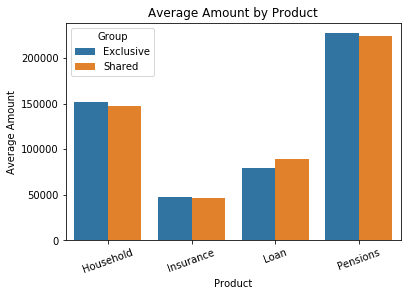

In [492]:
#appending aggregated data to a same dataframe to create a barchart with previous avg information
exc_agg2 = np.transpose(exc_agg)
exc_agg2["Group"] = "Exclusive"
shared_agg2 = np.transpose(shared_agg)
shared_agg2["Group"] = "Shared"
df = pd.concat([exc_agg2,shared_agg2])

df = df.reset_index()
df = df[df["index"].isin(["hh_avg","ins_avg","pens_avg","loan_avg"])]

ax = sns.barplot(x='index',y=0,hue="Group", data=df, ci=None)
ax.set_ylabel("Average Amount")
ax.set_xlabel("Product")
plt.xticks(np.arange(4), ('Household', 'Insurance', 'Loan', 'Pensions'))
plt.xticks(rotation=20)
plt.title('Average Amount by Product')

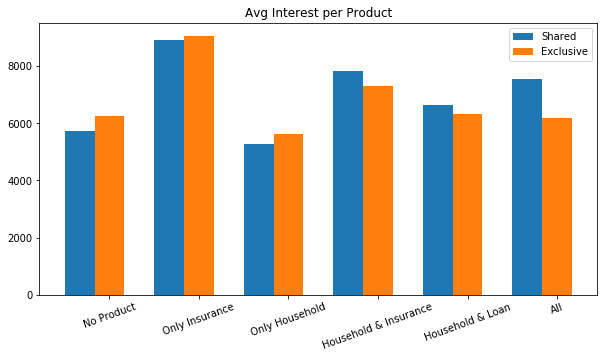

In [633]:
#Looking at product ownership (household, insurance & loan) to better understand the previous averages
#looking at interest amount as a way to measure profit
own_exc = exc_trans.groupby(["hh","ins","loan"])["trans_interest_amount"].agg(['sum','count']).reset_index()
own_exc["avg"] = own_exc["sum"]/own_exc["count"]
own_exc["n"] = own_exc["hh"]+own_exc["ins"]+own_exc["loan"]
own_exc2 = pd.DataFrame()
own_exc2[["Household","Loan","Insurance","Avg Interest","N","n"]] = own_exc[["hh","ins","loan","avg","count","n"]]
#own_exc2 = own_exc2.sort_values("Avg Interest")
own_exc2["Avg Interest"] =  round(own_exc2["Avg Interest"])
own_exc2.loc[(own_exc2["n"]==0),"Key"] = "No Product"
own_exc2.loc[(own_exc2["n"]==3),"Key"] = "All"
own_exc2.loc[(own_exc2["n"]==1)&(own_exc2["Household"]==1),"Key"] = "Only Household"
own_exc2.loc[(own_exc2["n"]==1)&(own_exc2["Insurance"]==1),"Key"] = "Only Insurance"
own_exc2.loc[(own_exc2["n"]==2)&(own_exc2["Insurance"]==0),"Key"] = "Household & Loan"
own_exc2.loc[(own_exc2["n"]==2)&(own_exc2["Loan"]==0),"Key"] = "Household & Insurance"
own_exc2 = own_exc2[["Key","Avg Interest","N"]]

own_sh = shared_trans.groupby(["hh","ins","loan"])["trans_interest_amount"].agg(['sum','count']).reset_index()
own_sh["avg"] = own_sh["sum"]/own_sh["count"]
own_sh["n"] = own_sh["hh"]+own_sh["ins"]+own_sh["loan"]
own_sh2 = pd.DataFrame()
own_sh2[["Household","Loan","Insurance","Avg Interest","N","n"]] = own_sh[["hh","ins","loan","avg","count","n"]]
#own_sh2 = own_sh2.sort_values("Avg Interest")
own_sh2["Avg Interest"] =  round(own_sh2["Avg Interest"])
own_sh2.loc[(own_sh2["n"]==0),"Key"] = "No Product"
own_sh2.loc[(own_sh2["n"]==3),"Key"] = "All"
own_sh2.loc[(own_sh2["n"]==1)&(own_sh2["Household"]==1),"Key"] = "Only Household"
own_sh2.loc[(own_sh2["n"]==1)&(own_sh2["Insurance"]==1),"Key"] = "Only Insurance"
own_sh2.loc[(own_sh2["n"]==2)&(own_sh2["Insurance"]==0),"Key"] = "Household & Loan"
own_sh2.loc[(own_sh2["n"]==2)&(own_sh2["Loan"]==0),"Key"] = "Household & Insurance"
own_sh2 = own_sh2[["Key","Avg Interest","N"]]

f = plt.figure(figsize=(10, 5))
indices = range(len(own_exc2["Key"]))
names = list(own_sh2["Key"])
# Calculate optimal width
width = np.min(np.diff(indices))/3.

ax = f.add_subplot(111)
p1 = ax.bar(indices-width/2.+1,own_sh2["Avg Interest"],width,label='Ymin')
p2 = ax.bar(indices+width/2.+1,own_exc2["Avg Interest"],width,label='Ymax')
plt.xticks(indices+width/2.+1,names)
ax.legend( (p1[0], p2[0]), ('Shared', 'Exclusive') )
plt.title('Avg Interest per Product')
plt.xticks(rotation=20)
plt.show()

Text(0.5, 1.0, 'Average Interest Amount by Number of Products')

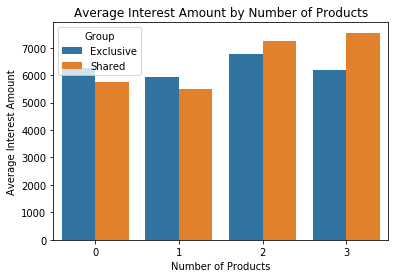

In [539]:
own_exc_n = own_exc.groupby("n")["sum"].sum()/own_exc.groupby("n")["count"].sum()
own_exc_n = own_exc_n.reset_index()
own_exc_n["Group"]="Exclusive"

own_shr_n = own_sh.groupby("n")["sum"].sum()/own_sh.groupby("n")["count"].sum()
own_shr_n = own_shr_n.reset_index()
own_shr_n["Group"]="Shared"

own_mrg = pd.concat([own_exc_n,own_shr_n])

ax = sns.barplot(x='n',y=0,hue="Group", data=own_mrg, ci=None)
ax.set_ylabel("Average Interest Amount")
ax.set_xlabel("Number of Products")
plt.title('Average Interest Amount by Number of Products')

# 4. Plots
Plots have been created for exploratory purposes to better understand client profiles

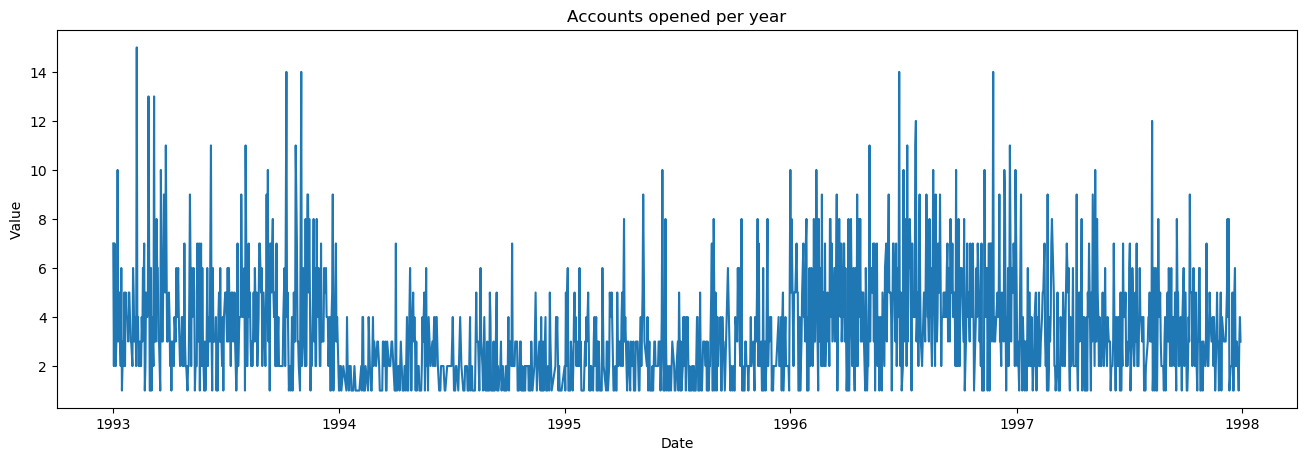

In [656]:
#accounts opened per date suggest no clear growth strategy
date_df = final_merge.groupby("acc_date")["acc_account_id"].count().reset_index()
date_df
# # Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(date_df, x=date_df.acc_date, y=date_df.acc_account_id, title='Accounts opened per year')  

In [807]:
date_df = final_merge.groupby("acc_date")["trans_sum_amount"].sum().reset_index()
date_df['year'] = [d.year for d in date_df.acc_date]
date_df = date_df.groupby("year")["trans_sum_amount"].mean().reset_index()
# # Draw Plot
# def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
#     plt.figure(figsize=(16,5), dpi=dpi)
#     plt.plot(x, y, color='tab:blue')
#     plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
#     plt.show()

# plot_df(date_df, x=date_df.acc_date, y=date_df.trans_sum_amount, title='Transaction amount per year')  

In [805]:
date_df

,acc_date,trans_sum_amount,year
0,1993-01-01,17923379.3,1993
1,1993-01-02,2948674.9,1993
2,1993-01-03,17656812.9,1993
3,1993-01-04,8563311.5,1993
4,1993-01-05,2862685.1,1993
5,1993-01-06,2069377.8,1993
6,1993-01-07,9717138.1,1993
7,1993-01-08,17196801.7,1993
8,1993-01-09,5199787.7,1993
9,1993-01-10,4487540.8,1993


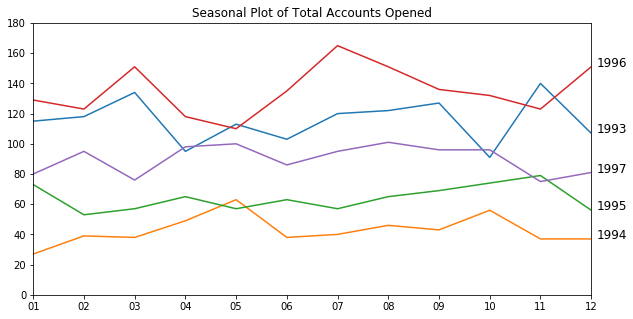

In [770]:
# Preparing data for seasonal analysis
df=pd.DataFrame()
df['year'] = [d.year for d in date_df.acc_date]
df['month'] = [d.strftime('%m') for d in date_df.acc_date]
df['value'] = [d for d in date_df.acc_account_id]
df = df.groupby(["year","month"])["value"].sum().reset_index()
years = df['year'].unique()

# # Prep Colors
np.random.seed(100)

# Draw Plot
mpl.rcParams['figure.figsize'] = (10.0, 5.0)
fig, ax = plt.subplots()
ax.set_xlim(0, 11)
ax.set_ylim(0, 180)
for i, y in enumerate(years):    
    plt.plot('month', 'value', data=df.loc[df.year==y, :], label=y)
    plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12)

plt.title("Seasonal Plot of Total Accounts Opened")
plt.show()
# No evidence of seasonality found

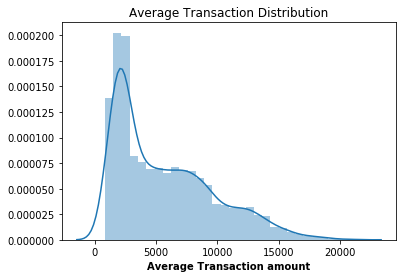

In [612]:
#right skew data: higher concentration in smaller avg amount
sns.distplot(final_merge['trans_avg_amount'])
plt.xlabel('Average Transaction amount', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
plt.title('Average Transaction Distribution')

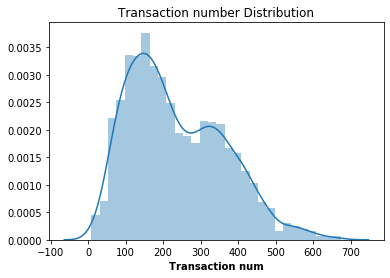

In [615]:
#higher concentration in mid-low transaction number
sns.distplot(final_merge['trans_n_trans'])
plt.xlabel('Transaction num', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
plt.title('Transaction number Distribution')
plt.savefig('fig_'+str('Transaction number Distribution')+'.png', dpi=200,bbox_inches="tight")
#plt.show()

Text(0.5, 1.0, 'Number of Accounts per Loan Status')

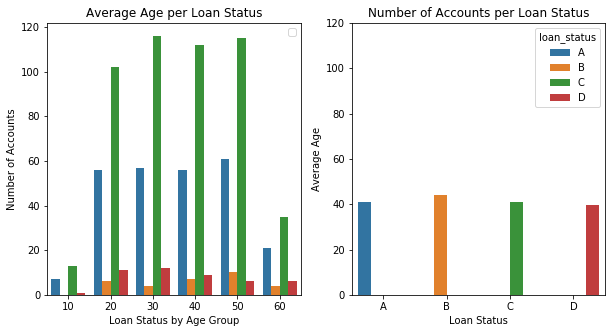

In [797]:
#Age x loan status
df = final_merge.groupby(["loan_status","cust_age_group"])["acc_account_id"].count().reset_index()
df = df[df["loan_status"]!="NA"]

f = plt.figure(figsize=(10, 5))
f.add_subplot(1,2,1)
ax = sns.barplot(x='cust_age_group',y="acc_account_id",hue="loan_status", data=df, ci=None)
ax.set_ylabel("Number of Accounts")
ax.set_xlabel("Loan Status by Age Group")
ax.legend("")
plt.title('Average Age per Loan Status')

df = final_merge.groupby(["loan_status"])["cust_age"].mean().reset_index()
df = df[df["loan_status"]!="NA"]

f.add_subplot(1,2,2)
ax1 = sns.barplot(x='loan_status',y="cust_age",hue="loan_status", data=df, ci=None)
ax1.set_ylabel("Average Age")
ax1.set_xlabel("Loan Status")
ax1.set_ylim(0,120)
plt.title('Number of Accounts per Loan Status')

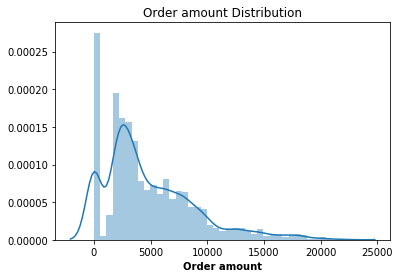

In [614]:
#skew similar to transaction data
sns.distplot(final_merge['ord_amount'])
plt.xlabel('Order amount', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
plt.title('Order amount Distribution')
#plt.savefig('fig_'+str('Order amount Distribution')+'.png', dpi=200,bbox_inches="tight")

# 5. Conclusions

There are several differences between the segments of exclusive and shared account, it is difficult to tell if these differences are notorious. As a further step, it would be interesting to carry out statistical significance tests to determine if these segments are behaving in a significantly different way. 

Additionally, it may be worth rethinking the interest rates associated to each banking product (Household, Loan and Insurance), as they do not seem to be aligned with a strong growth strategy. This hypothesis of lack of a clear growth strategy is also backed up by the lack of evident patterns in account opening and transaction amounts being concentrated on smaller amounts, with an overall trend of amount decrease throughout the years.
